# 1
# PPFQ

## Data Mining

-48-

Buscamos patrones o indicadores que nos brinden señales.

Ejemplo: dos indicadores

objetivo: investigar entre muchos indicadores, correlaciones contra el precio, o el retorno futuro del mismo.

"Testear bot de trading del tipo trend-following, con cruce de medias y oscilador tipo RSI."

In [15]:
from dotenv import load_dotenv
import os
from apps.forex_api import fx_price
import pandas as pd
import numpy as np
import seaborn as sns


load_dotenv()
TOKEN = os.environ["TOKEN_AV"]
# data = fx_price("FX_DAILY", "EUR", "USD", TOKEN)

In [16]:
# data.to_csv('data-daily-raw.csv')

data = pd.read_csv("data-daily-raw.csv", index_col=0)

In [17]:
# PARAMETROS INCIALES
ruedas = 14
par = "EUR/JPY"
fast, slow = 20, 60
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"]  # atributo dinámico
forwards = [f"fw_{i}" for i in fw]  # atributo preseteado, dinámico

In [18]:
# AJUSTE DE DATA
new_labels = ["Open", "High", "Low", "Close"]

data.rename(dict(zip(data.columns, new_labels)), axis=1, inplace=True)

data = data.iloc[-1::-1]

In [19]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "Close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "Close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = (
        dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] * 100 - 100
    )
    return data


data = cruce_sma_fast_slow(data, fast, slow)


# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data.Close.diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1 / ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1 / ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1 + dataux.loc[:, "rs"]))
    return data


data = rsi(data, ruedas)


# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "Close"].pct_change() * 100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (
        sigma**0.5
    )
    return data


data = volatilidad(data, sigma)


def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data.Close.shift(-step) / data.Close.shift() - 1) * 100
    return data


data = forward(data, fw)


def ajustar_datos(data, features):
    data = data.iloc[:, 3:].dropna()
    data.loc[:, features] = data.loc[:, features].shift()
    return data.round(4)


data = ajustar_datos(data, features)

data

,Close,Cruce_20_60,rsi,variacion,sigma_40,fw_10,fw_20
2003-11-20,129.650,NaN,NaN,-0.1617,NaN,0.7778,2.9878
2003-11-21,129.670,-0.9752,62.2079,0.0154,3.9843,1.0181,3.0081
2003-11-24,128.790,-0.9718,62.3001,-0.6786,3.9648,1.2185,2.8842
2003-11-25,129.000,-0.9318,55.8489,0.1631,4.0250,1.7237,3.3232
2003-11-26,130.030,-0.8794,56.9934,0.7984,3.8372,2.5349,3.5271
...,...,...,...,...,...,...,...
2022-09-26,139.028,1.8442,41.2774,0.0792,4.3540,1.7809,5.9006
2022-09-27,138.935,1.8848,41.8458,-0.0669,4.2534,1.7723,6.1642
2022-09-28,140.264,1.8893,41.4802,0.9566,4.2536,2.6005,6.2007
2022-09-29,141.805,1.8850,48.4150,1.0986,4.3178,2.5866,3.9476


[(-10.0, 10.0)]

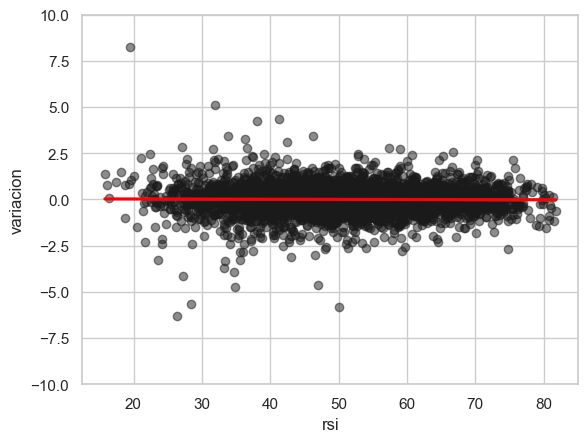

In [20]:
# Look-Ahead Bias
"""Es necesario tomar todos los indicadores y atrasarlos un día, porque "hoy operamos con los indicadores de ayer" """


"""
La tarea a realizar es determinar si existe correlación entre las features y la fluctuación del precio.
También identificar si generan algún tipo de clasificación diferenciable.
"""

sns.set(style="whitegrid")
g = sns.regplot(
    x="rsi",
    y="variacion",
    data=data,
    line_kws={"color": "red"},
    scatter_kws={"color": "k", "alpha": 0.5},
)

g.set(ylim=(-10, 10))

### Correlación features vs variación

-51-

In [21]:
for feature in features:
    r2 = data[feature].corr(data.variacion)
    print(f"El r2 con {feature} es {r2:.2f}")

El r2 con Cruce_20_60 es -0.00
El r2 con rsi es -0.01
El r2 con sigma_40 es -0.01


In [22]:
# TODO: la variable "variacion" está hardcodeada, esto se soluciona creando una clase
data.corr().loc[["variacion"] + forwards, features].round(2)

,Cruce_20_60,rsi,sigma_40
variacion,-0.00,-0.01,-0.01
fw_10,0.00,-0.01,-0.04
fw_20,0.03,-0.02,-0.06


### Clasificación diferenciable

-55-

La cuestión es separar los variacion expost (fw) si el indicador refleja alguna diferencia o no.

In [23]:
data["variacion_tipo"] = np.where(data.variacion > 0, "Up", "Down")

medias = data.groupby("variacion_tipo").mean().loc[:, features].round(2)
desvios = data.groupby("variacion_tipo").std().loc[:, features].round(2)

print(f"Medias según clasificación \n{medias}\n")
print(f"Desvíos según clasificación \n{desvios}\n")

Medias según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   0.05  51.26      4.09
Up                     0.03  50.79      4.03

Desvíos según clasificación 
                Cruce_20_60    rsi  sigma_40
variacion_tipo                              
Down                   2.09  11.74      2.04
Up                     1.93  11.60      1.93



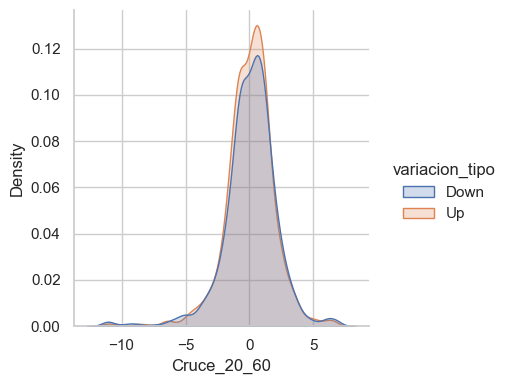

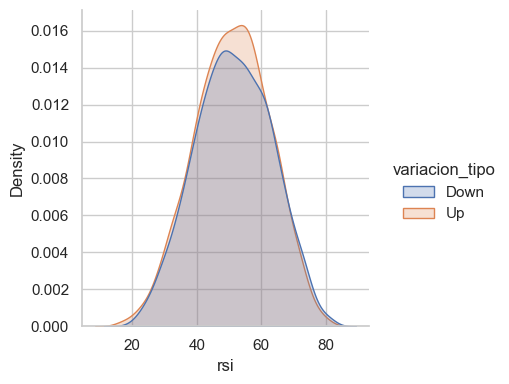

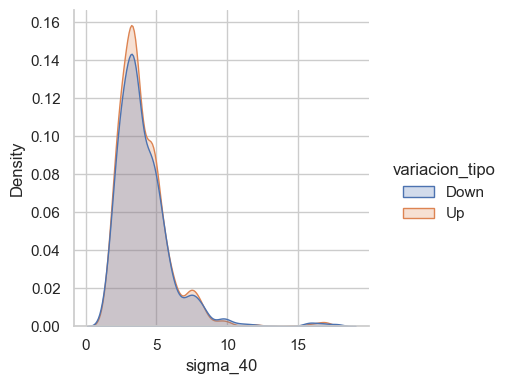

In [24]:
for feature in features:
    sns.displot(data, x=feature, hue="variacion_tipo", kind="kde", height=4, fill=True)

## Construcción de indicadores

-57-